In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
import os, h5py
import tensorflow as tf

from tqdm import tqdm
from numba import njit

from msfm.utils.io import read_yaml
from msfm.utils.maps import make_normallized_maps

In this notebook, the underlying galaxy number map $\delta$ is fixed to the Metacal catalog. The noise files are generated in `generate_noise.py`

### global constants

In [2]:
conf_dir = "../../configs/config.yaml"
conf = read_yaml(conf_dir)

n_side = conf["analysis"]["n_side"]
n_pix = conf["analysis"]["n_pix"]

l_max = 2*n_side

# Metacal tomo bin
tomo = 1
component = "g1"

# load noise

In [3]:
janis_noise = np.load("/Users/arne/data/CosmoGrid_example/DES/noise/noise_patches.npz")
print(janis_noise["gamma1"].shape)
print(janis_noise["gamma_cls"].shape)

(10, 463872, 5)
(10, 1536, 5)


In [4]:
rot_noise = np.load("../../scripts/noise_models/data/rotate_in_place.npz")
print(rot_noise["g1"].shape)

emp_noise = np.load("../../scripts/noise_models/data/sample_empirical_dist.npz")
print(emp_noise["g1"].shape)

(100, 3145728)
(100, 3145728)


### single realization

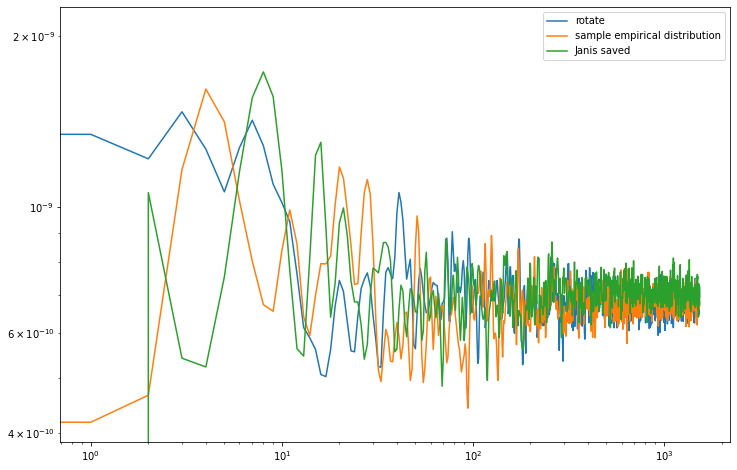

In [5]:
fig, ax = plt.subplots(figsize=(12,8))

cls = hp.anafast(rot_noise[component][0], use_pixel_weights=True)
ax.loglog(cls, label="rotate")

cls = hp.anafast(emp_noise[component][0], use_pixel_weights=True)
ax.loglog(cls, label="sample empirical distribution")

ax.loglog(janis_noise["gamma_cls"][0,:,tomo], label="Janis saved")

ax.legend()

### mean over N realizations

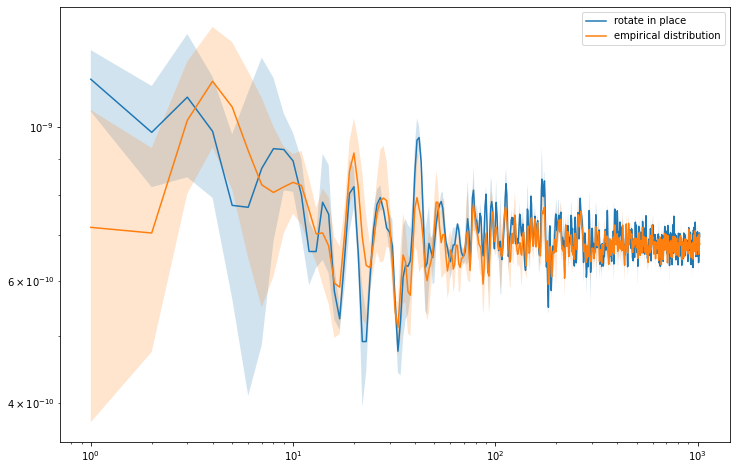

In [6]:
noise_maps = [rot_noise, emp_noise]
noise_types = ["rotate in place", "empirical distribution"]
N = len(rot_noise)
component = "g1"

fig, ax = plt.subplots(figsize=(12,8))

cls = []
for noise_map, noise_type in zip(noise_maps, noise_types):
    noise_map = noise_map[component]
    
    for i in range(N):
        cls.append(hp.anafast(noise_map[i], use_pixel_weights=True))

    cls_mean = np.mean(cls, axis=0)
    cls_std = np.std(cls, axis=0)/np.sqrt(N)

    l = np.arange(1, l_max)
    ax.loglog(l, cls_mean[l], label=noise_type)
    ax.fill_between(l, cls_mean[l]-cls_std[l], cls_mean[l]+cls_std[l], alpha=0.2)

ax.legend()